<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Модель</a></span>

# Восстановление золота из руды

**Задача проекта** - подготовка прототипа модели машинного обучения для компании «Цифры», которая разрабатывает решения для эффективной работы промышленных предприятий.  

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, и поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  

**План работ:**  
1. Подготовка данных 
   - изучение данных;
   - проверка корректности расчёта эффективность обогащения, вычисление её на обучающей выборке для признака   
     rougher.output.recovery, нахождение MAE между расчётами и значением признака;
   - анализ признаков, недоступных в тестовой выборке.  
2. Предобработка данных  
3. Анализ данных  
    - анализ изменения концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате
      после первой очистки и в финальном концентрате.
    - сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках. 
    - исследование суммарной концентрации металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после   
      первой очистки и в финальном концентрате.  
4. Построение модели  
5. Функция для вычисления итоговой sMAPE  
6. Обучение разных модели и оценка их качества кросс-валидацией 
7. Выбор лучшей модели и проверка её на тестовой выборке 
8. Подведение итогов  


## Подготовка данных

**Описание данных:**  

Характеристики и признаки:  

-rougher feed — исходное сырье  
-rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
-xanthate — ксантогенат (промотер, или активатор флотации)  
-sulphate — сульфат (на данном производстве сульфид натрия)   
-depressant — депрессант (силикат натрия)  
-rougher process (англ. «грубый процесс») — флотация  
-rougher tails — отвальные хвосты  
-float banks — флотационная установка  
-cleaner process — очистка  
-rougher au — черновой концентрат золота   
-final fu — финальный концентрат золота  

Параметры этапов обозначены следующим образом:  

-air amount — объём воздуха  
-fluid levels — уровень жидкости  
-feed size — размер гранул сырья  
-feed rate — скорость подачи  

Возможные значения для блока [этап]:  

-rougher — флотация  
-primary_cleaner — первичная очистка  
-secondary_cleaner — вторичная очистка  
-final — финальные характеристики  

Возможные значения для блока [тип_параметра]:  
  
-input — параметры сырья  
-output — параметры продукта  
-state — параметры, характеризующие текущее состояние этапа  
-calculation — расчётные характеристики  

Название признаков складывается следующим образом:   

[этап].[тип_параметра].[название_параметра]  

In [1]:
#импорт библиотек и модулей
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, make_scorer
import scipy.stats as stats
from scipy.stats import ttest_ind, randint, uniform
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
#загрузка датафреймов и просмотр сэмплов
df_train = pd.read_csv('gold_industry_train.csv', parse_dates=['date'])
df_test = pd.read_csv('gold_industry_test.csv', parse_dates=['date'], dayfirst=True)
df_full = pd.read_csv('gold_industry_full.csv', parse_dates=['date'], dayfirst=True)
df_train.name, df_test.name, df_full.name = 'обучающая выборка', 'тестовая выборка', 'исходный набор'
display(df_full.sample(5))
display(df_train.head())
display(df_test.head())

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
9839,2017-04-30 17:59:59,8.432,7.744,3.390,42.932,604.130,60.378,17.001,6.999,997.558,-299.828,1303.232,-500.639,1253.905,-500.032,1202.719,-499.657,998.986,-499.693,1000.014,-500.166,17.001,7.000,47968.538,3402.117,3402.276,2.487,18.558,11.721,7.919,28.519,89.039,1.552,3.840,0.643,20.755,206.902,8.515,7.200,1.511,1600.150,-499.902,1602.348,-499.031,1599.056,-499.980,1601.650,-499.557,29.851,9.717,11.509,10.427,3.534,14.860,2.833,9.104,27.966,-500.111,22.921,-501.410,21.966,-500.189,13.996,-499.925,12.023,-501.322,9.028,-409.069,9.036,-500.561,6.938,-500.266,9.990,-500.880,4.475,17.474,7.510,4.199,44.248,5.013,11.514,8.439,72.825,2.661,8.082,2.789,12.265
1108,2016-03-04 23:00:00,7.191,7.282,2.140,34.687,520.517,58.215,9.997,7.497,999.698,-500.023,1500.900,-499.822,1549.943,-500.692,1499.486,-500.601,1298.913,-501.780,1199.548,-500.097,9.997,7.498,40026.003,3413.070,3413.590,3.360,17.774,10.196,6.981,20.676,83.288,1.812,5.585,0.726,19.837,94.720,12.100,7.860,1.195,1598.183,-400.008,1600.562,-400.911,1600.774,-400.296,612.151,-399.512,39.687,7.566,6.928,13.6

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486,6.100,2.285,36.809,523.546,55.487,11.987,6.008,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,11.837,6.006,41885.707,3481.779,3520.337,2.839,19.794,11.501,7.101,28.029,87.108,1.170,5.008,0.509,19.154,127.092,10.128,7.250,0.989,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,34.174,8.548,10.390,19.529,2.107,14.937,2.535,7.476,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842,2.606,14.500,4.695,8.765,42.192,6.055,9.890,5.507,70.541,2.143,10.412,0.895,16.904
1,2016-01-15 01:00:00,6.479,6.161,2.266,35.753,525.291,57.279,11.971,6.006,1000.286,-400.065,1600.755,-449.953,1600.480,-449.831,1600.528,-449.954,1399.227,-450.870,1399.720,-450.119,11.996,6.013,42050.862,3498.371,3489.982,2.859,20.051,11.616,7.279,28.067,86.843,1.185,4.955,0.537,18.965,125.629,10.296,7.250,1.003,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,34.119,8.559,10.497,

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365,6.159,3.876,39.135,555.820,94.544,6.147,9.309,1196.238,-299.863,1147.248,-500.363,1047.279,-500.354,948.757,-498.439,849.442,-499.256,850.112,-499.407,6.169,9.310,95.248,8.079,6.500,1.283,1648.760,-399.862,1650.135,-399.957,1648.832,-400.586,1649.465,-400.673,34.941,-500.151,30.032,-500.328,26.034,-500.148,22.952,-500.038,23.019,-500.493,20.020,-500.220,17.964,-499.939,12.990,-500.081,19.990,-499.192
1,2017-12-09 15:59:59,4.363,6.048,3.903,39.714,544.732,123.742,6.210,9.298,1201.904,-299.907,1154.088,-500.037,1054.010,-500.237,944.139,-496.867,851.590,-499.040,851.346,-499.123,6.210,9.297,98.881,7.984,6.500,1.242,1646.548,-398.977,1648.212,-400.383,1648.917,-399.521,1651.499,-399.745,34.981,-498.131,29.968,-586.013,25.972,-499.608,22.958,-499.821,23.025,-501.153,20.054,-500.315,17.980,-499.273,12.992,-499.976,20.014,-500.625
2,2017-12-09 16:59:59,5.082,6.083,4.564,37.209,558.155,82.611,7.364,9.004,1200.827,-300.124,1150.755,-499.986,1049.183,-500.015,948.085,-499.997,850.170,-500.270,849.558,-500.199,7.358,9.001,119.498,8.004,6.500,1.260,1647.369,-399.789,1648.395,-400.166,1648.954,-400.469,1649.822,-400.072,34.953,-501.205,29.927,-500.107,25.978,-499.890,23.004,-500.015,22.994,-501.560,20.029,-500.001,18.013,-500.025,13.016,-500.058,19.974,-501.394
3,2017-12-09 17:59:59,5.146,6.084,4.768,36.809,539.714,77.985,6.927,8.956,1199.292,-299.778,1152.513,-500.338,1052.602,-499.695,955.172,-500.295,851.957,-499.780,850.766,-501.031,6.929,8.921,108.080,7.970,6.660,0.775,1652.661,-399.702,1651.203,-400.291,1651.925,-398.058,1650.783,-399.598,35.038,-500.103,30.067,-500.211,26.014,-500.055,22.989,-499.981,23.033,-501.288,19.977,-500.160,17.980,-500.505,12.949,-500.010,20.010,-508.338
4,2017-12-09 18:59:59,5.735,6.165,4.512,37.811,558.714,86.435,7.823,7.490,1198.005,-300.283,1099.481,-499.702,999.539,-499.306,889.446,-498.119,800.534,-499.765,800.510,-497.290,7.825,7.501,117.751,6.954,6.427,0.731,1649.411,-399.853,1648.917,-400.322,1649.118,-399.645,1650.398,-400.655,34.895,-498.445,30.021,-533.831,26.022,-499.725,22.993,-499.891,23.002,-499.948,20.024,-499.714,17.991

In [3]:
def data_info(dataframe):
    print('Информация по датафрейму', dataframe.name)
    print('Общая информация:')
    display(dataframe.info())
    print('\nПосмотрим пропуски:')
    display(dataframe.isnull().sum().sort_values(ascending=False))
    print('\nПосмотрим на описание датафрейма:')
    display(dataframe.describe())
    print('\nКоличество дубликатов:')
    display(dataframe.duplicated().sum())

In [4]:
data_info(df_full)

Информация по датафрейму исходный набор
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   rougher.input.feed_au                               19439 non-null  float64       
 2   rougher.input.feed_ag                               19439 non-null  float64       
 3   rougher.input.feed_pb                               19339 non-null  float64       
 4   rougher.input.feed_sol                              19340 non-null  float64       
 5   rougher.input.feed_rate                             19428 non-null  float64       
 6   rougher.input.feed_size                             19294 non-null  float64       
 7   rougher.input.floatbank10_sulfate   

None


Посмотрим пропуски:


secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
                                            ... 
rougher.output.tail_sol                        0
primary_cleaner.input.feed_size                0
rougher.input.feed_au                          0
primary_cleaner.output.concentrate_au          0
date                                           0
Length: 87, dtype: int64


Посмотрим на описание датафрейма:


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000,19439.000,19339.000,19340.000,19428.000,19294.000,19405.000,19431.000,19438.000,19438.000,19438.000,19438.000,19438.000,19438.000,19439.000,19439.000,19003.000,19439.000,19439.000,19439.000,19395.000,18986.000,19437.000,19437.000,19437.000,19439.000,19439.000,19439.000,19439.000,19416.000,19439.000,19439.000,19438.000,19439.000,19439.000,19415.000,19402.000,19439.000,19335.000,19435.000,19438.000,19435.000,19438.000,19437.000,19438.000,19436.000,19438.000,19439.000,19439.000,19323.000,19069.000,19439.000,19435.000,19418.000,19377.000,19219.000,19438.000,19416.000,19438.000,19426.000,19438.000,19438.000,19438.000,19433.000,19438.000,19438.000,19438.000,19438.000,19438.000,19438.000,19438.000,19437.000,19438.000,19439.000,19437.000,19427.000,17691.000,19439.000,19438.000,19438.000,19228.000,19439.000,19439.000,19438.000,19338.000,19433.000
mean,8.266,8.795,3.598,36.695,478.320,58.970,12.334,6.021,1105.315,-376.611,1320.221,-467.248,1299.969,-467.717,1211.563,-468.240,1080.870,-466.038,1025.274,-466.265,12.064,6.066,42171.189,3393.052,3256.854,2.42


Количество дубликатов:


0

In [5]:
data_info(df_train)

Информация по датафрейму обучающая выборка
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14579 non-null  datetime64[ns]
 1   rougher.input.feed_au                               14579 non-null  float64       
 2   rougher.input.feed_ag                               14579 non-null  float64       
 3   rougher.input.feed_pb                               14507 non-null  float64       
 4   rougher.input.feed_sol                              14502 non-null  float64       
 5   rougher.input.feed_rate                             14572 non-null  float64       
 6   rougher.input.feed_size                             14478 non-null  float64       
 7   rougher.input.floatbank10_sulfate

None


Посмотрим пропуски:


secondary_cleaner.output.tail_sol           920
rougher.state.floatbank10_e_air             429
rougher.input.floatbank11_xanthate          407
primary_cleaner.output.concentrate_sol      265
final.output.concentrate_sol                192
                                           ... 
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_level      0
primary_cleaner.output.concentrate_au         0
primary_cleaner.state.floatbank8_b_level      0
Length: 87, dtype: int64


Посмотрим на описание датафрейма:


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000,14579.000,14507.000,14502.000,14572.000,14478.000,14548.000,14572.000,14579.000,14579.000,14579.000,14579.000,14579.000,14579.000,14579.000,14579.000,14150.000,14579.000,14579.000,14579.000,14543.000,14172.000,14578.000,14578.000,14578.000,14579.000,14579.000,14579.000,14579.000,14561.000,14579.000,14579.000,14578.000,14579.000,14579.000,14556.000,14551.000,14579.000,14518.000,14576.000,14579.000,14576.000,14579.000,14579.000,14579.000,14578.000,14579.000,14579.000,14579.000,14491.000,14314.000,14579.000,14575.000,14573.000,14534.000,14485.000,14579.000,14557.000,14579.000,14567.000,14579.000,14579.000,14579.000,14574.000,14579.000,14579.000,14579.000,14579.000,14579.000,14579.000,14579.000,14578.000,14579.000,14579.000,14578.000,14575.000,13659.000,14579.000,14578.000,14578.000,14387.000,14579.000,14579.000,14578.000,14504.000,14574.000
mean,8.353,8.877,3.604,36.561,474.333,58.923,12.427,5.995,1104.208,-379.367,1322.846,-465.495,1302.745,-465.989,1214.062,-466.526,1082.778,-464.228,1025.776,-464.549,12.096,6.047,44352.188,3440.548,3276.812,2.43


Количество дубликатов:


0

In [6]:
data_info(df_test)

Информация по датафрейму тестовая выборка
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        4860 non-null   datetime64[ns]
 1   rougher.input.feed_au                       4860 non-null   float64       
 2   rougher.input.feed_ag                       4860 non-null   float64       
 3   rougher.input.feed_pb                       4832 non-null   float64       
 4   rougher.input.feed_sol                      4838 non-null   float64       
 5   rougher.input.feed_rate                     4856 non-null   float64       
 6   rougher.input.feed_size                     4816 non-null   float64       
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64       
 8   rougher.input.floatbank10_xa

None


Посмотрим пропуски:


secondary_cleaner.state.floatbank2_a_air      126
rougher.input.floatbank11_xanthate             46
rougher.input.feed_size                        44
primary_cleaner.input.xanthate                 43
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
primary_cleaner.input.depressant                9
rougher.input.floatbank11_sulfate               8
rougher.state.floatbank10_e_air                 7
rougher.input.feed_rate                         4
rougher.input.floatbank10_sulfate               3
primary_cleaner.state.floatbank8_d_air          2
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_d_level        1
secondary_cleaner.state.floatbank3_a_level      1
secondary_cleaner.state.floatbank2_a_level      1
secondary_cleaner.state.floatbank2_b_air        1
secondary_cleaner.state.floatbank2_b_level      1
secondary_cleaner.state.floatbank3_a_air        1
secondary_cleaner.state.floatbank4_a_air        1



Посмотрим на описание датафрейма:


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000,4860.000,4832.000,4838.000,4856.000,4816.000,4857.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4860.000,4860.000,4853.000,4860.000,4860.000,4860.000,4852.000,4814.000,4859.000,4851.000,4860.000,4817.000,4859.000,4859.000,4859.000,4859.000,4858.000,4859.000,4858.000,4859.000,4734.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000,4859.000
mean,8.006,8.547,3.580,37.096,490.285,59.113,12.056,6.101,1108.636,-368.340,1312.346,-472.507,1291.638,-472.903,1204.067,-473.381,1075.305,-471.466,1023.770,-471.413,11.969,6.119,143.202,8.692,7.306,1.008,1588.387,-488.223,1589.297,-490.256,1588.905,-489.742,1530.288,-485.896,29.488,-499.505,24.732,-499.557,28.896,-489.475,22.633,-494.766,19.858,-488.665,15.570,-464.177,16.594,-490.815,12.946,-489.584,19.054,-504.679
std,1.994,1.959,1.029,4.926,94.372,19.125,3.408,1.043,156.493,91.156,159.002,49.377,180.204,47.612,184.548,47.829,159.990,51.414,147.828,51.839,3.456,1.049,42.360,3.170,0.589,0.495,124.943,36.673,132.103,35.204,132.689,33.651,256.269,43.296,5.358,43.284,5.484,43.620,6.159,51.827,5.457,40.681,5.913,44.393,4.927,65.707,5.724,32.258,5.533,37.085,5.549,38.690
min,0.010,0.010,0.010,0.010,0.013,0.046,0.019,0.016,300.792,-600.568,767.657,-649.997,831.538,-552.657,706.282,-648.118,695.212,-598.926,539.634,-649.376,0.000,0.003,7.329,0.000,4.970,0.000,314.241,-653.478,319.959,-799.261,273.537,-709.214,131.322,-799.792,0.122,-799.606,0.000,-799.874,0.000,-799.575,0.000,-758.764,0.000,-799.705,0.000,-799.861,-0.371,-797.142,1.358,-800.006,0.160,-809.735
25%,6.574,6.976,2.904,34.511,434.100,47.597,9.890,5.500,999.716,-499.732,1199.742,-500.219,1152.402,-500.226,1061.682,-500.441,998.898,-500.267,949.042,-500.535,9.822,5.500,113.294,6.043,6.940,0.700,1505.500,-500.272,1502.105,-500.422,1501.205,-500.677,1450.606,-500.438,25.116,-500.215,22.039,-500.223,24.980,-500.212,19.012,-500.120,15.011,-500.704,12.022,-500.197,11.074,-500.484,9.012,-500.130,14.964,-500.669
50%,7.813,8.180,3.541,37.500,502.119,55.509,11.998,6.100,1001.415


Количество дубликатов:


0

In [7]:
#посмотрим на размеры датасетов
print(f'Исходный набор: {df_full.shape}' 
      f'\nТренировочная выборка: {df_train.shape}'
      f'\nТестовая выборка: {df_test.shape}'
      f'\nТренировочная + тестовая выборки: '
      f'{df_train.shape[0] + df_test.shape[0]}')

Исходный набор: (19439, 87)
Тренировочная выборка: (14579, 87)
Тестовая выборка: (4860, 53)
Тренировочная + тестовая выборки: 19439


Во всех таблицах имеются пропуски в разных столбцах, кроме столбца с датой. Больше всего информации содержится в датасете full, поэтому при предобработке данных добавим недостающие данные в трейн и тест из него. В качестве индекса примем столбцы с датами во всех датасетах

In [8]:
# примем дату в качестве индекса
df_full = df_full.set_index('date')
df_test = df_test.set_index('date')
df_train = df_train.set_index('date')

**Признаки, недоступные в тестовой выборке**

In [9]:
#посмотрим на столбцы, отсутствующие в тестовой выборке
missing_features = set(df_train.columns) ^ set(df_test.columns)
display(missing_features)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют:  
    - 9 столбцов, характеризующие финальные характеристики продукта (final.output);   
    - 8 столбцов, характеризующие продукт на этапе первичной очистки (primary_cleaner.output);   
    - 4 столбца, характеризующих расчетные характеристики на этапе флотации (rougher.calculation);   
    - 9 столбцов, характеризующих продукт на выходе с этапа флотации (rougher.output);   
    - 4 столбца, характеризующие продукт на этапе вторичной очистки (secondary_cleaner.output).   
Итого 34 столбца, которые описывают продукт на выходе с разных стадий (output) или получены расчетным путем (calculation).  
Целевые признаки rougher.output.recovery и final.output.recovery, соответственно, тоже отсутствуют.  
Логично это связать с тем, что отсутствующие данные получаются позже по ходу технологического процесса и на тесте их быть не должно. Использовать их в модели не стоит, так как они могут приводить к утечке целевого признака, но таргеты добавить будет нужно.  


**Проверка корректности расчёта эффективности обогащения**

Вычислим эффективность обогащения её на обучающей выборке для нашей целевой переменной - признака rougher.output.recovery и найдём MAE между своими расчётами и значением признака.   
Эффективность обогащения находим по формуле:  
Recovery = C*(F - T) / F*(C - T) * 100%  
где:   
C — доля золота в концентрате после флотации/очистки (rougher.output.concentrate_au);  
F — доля золота в сырье/концентрате до флотации/очистки (rougher.input.feed_au);  
T — доля золота в отвальных хвостах после флотации/очистки (rougher.output.tail_au).  

In [10]:
mae_recovery = df_train[['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']]
mae_recovery.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rougher.output.recovery        14579 non-null  float64
 1   rougher.output.concentrate_au  14579 non-null  float64
 2   rougher.input.feed_au          14579 non-null  float64
 3   rougher.output.tail_au         14579 non-null  float64
dtypes: float64(4)
memory usage: 569.5 KB


Метрика МАЕ не считает NaN, избавимся от таких строк.

In [11]:
C = mae_recovery.loc[mae_recovery['rougher.output.recovery'].notnull(), 'rougher.output.concentrate_au']
F = mae_recovery.loc[mae_recovery['rougher.output.recovery'].notnull(), 'rougher.input.feed_au']
T = mae_recovery.loc[mae_recovery['rougher.output.recovery'].notnull(), 'rougher.output.tail_au']

mae = mean_absolute_error((C * (F - T) / (F * (C - T)) * 100), 
                          mae_recovery.loc[mae_recovery['rougher.output.recovery'].notnull(), 'rougher.output.recovery'])
mae

9.83758577644259e-15

MAE ничтожно мала, значит, рассчитанный признак recovery можем считать верным.

## Предобработка данных

В процессе предобработки данных нужно выполнить следующие шаги:  

Проанализировать и исключить нулевые аномалии и NaN из целевых признаков;  
Обработать (заполнить) пропуски в обучающих признаках;  
Добавить целевые признаки в тестовую выборку.  

Посмотрим распределение целевых признаков

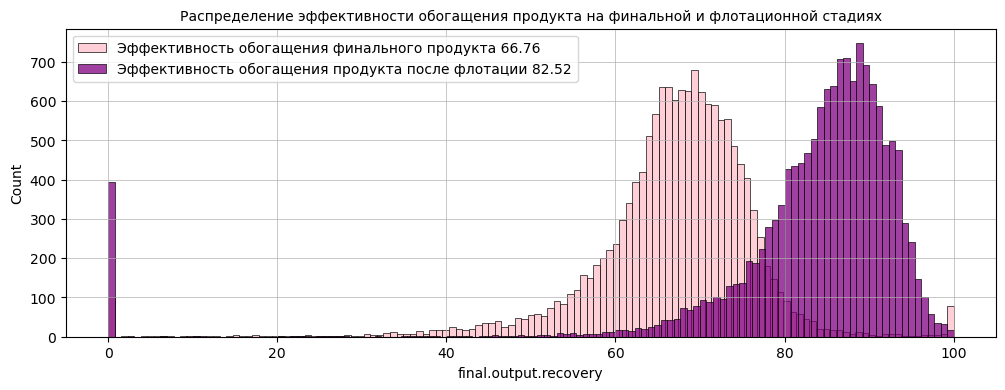

In [12]:
plt.figure(figsize=(12,4))
sns.histplot(df_train['final.output.recovery'], color='pink', label=f'Эффективность обогащения финального продукта {df_train["final.output.recovery"].mean():.2f}')
sns.histplot(df_train['rougher.output.recovery'], color='purple', label=f'Эффективность обогащения продукта после флотации {df_train["rougher.output.recovery"].mean():.2f}')
#plt.minorticks_on()
plt.grid(which='major', linewidth=.5)
plt.grid(which='minor', axis='y', linewidth=.25, linestyle='--')
plt.title('Распределение эффективности обогащения продукта на финальной и флотационной стадиях', fontsize=10)
plt.legend();

In [13]:
target_test = df_full[df_full.index.isin(df_test.index)][['rougher.output.recovery', 'final.output.recovery']]

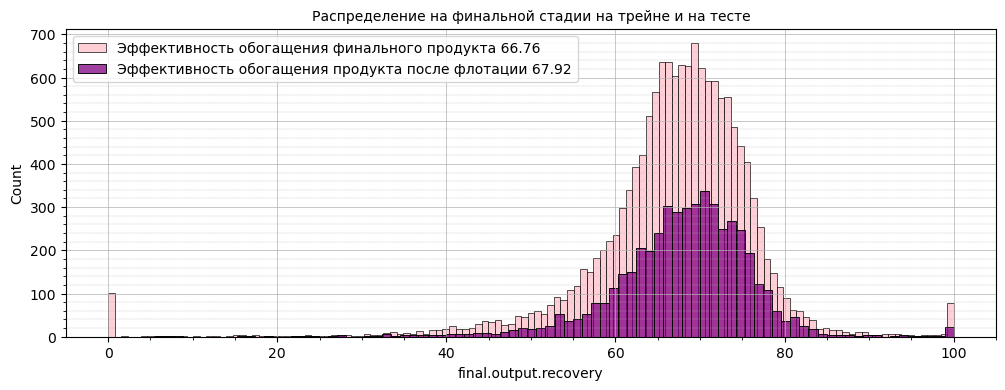

In [14]:
plt.figure(figsize=(12,4))
sns.histplot(df_train['final.output.recovery'], color='pink', label=f'Эффективность обогащения финального продукта {df_train["final.output.recovery"].mean():.2f}')
sns.histplot(target_test['final.output.recovery'], color='purple', label=f'Эффективность обогащения продукта после флотации {target_test["final.output.recovery"].mean():.2f}')
plt.minorticks_on()
plt.grid(which='major', linewidth=.5)
plt.grid(which='minor', axis='y', linewidth=.25, linestyle='--')
plt.title('Распределение на финальной стадии на трейне и на тесте', fontsize=10)
plt.legend();

In [15]:
target_variables = ['rougher.output.recovery', 'final.output.recovery']
targets = df_train[target_variables]
print(df_train[target_variables].isna().sum())

rougher.output.recovery    0
final.output.recovery      0
dtype: int64


Заполнение пропусков в тестовой выборке синтетическими данными может привести к искажению результатов. 
Поэтому строки с пропущенными значениями в тестовой выборке удалим.

In [16]:
df_test.dropna(inplace=True)

Для df_train заполним пропуски в нецелевых признаках.   
Как сказано в задании от заказчика, соседние данные часто похожи.
Для заполнения отсутствующих данных воспользуемся методом «ffill», он означает «прямое заполнение» и будет распространять последнее действительное наблюдение вперед. При этом наиболее правильным будет заполнить общий датасет, т.к. в нем содержатся все данные, идущие друг за другом, а далее эти же данные записать в трейн и тест.

In [17]:
df_full = df_full.fillna(method='ffill')
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')

# Проверим:
print('Количество пропущенных значений в исходных данных:', df_full.isnull().sum().sum())
print('Количество пропущенных значений в тренировочной выборке:', df_train.isnull().sum().sum())
print('Количество пропущенных значений в тестовой выборке:', df_test.isnull().sum().sum())

Количество пропущенных значений в исходных данных: 0
Количество пропущенных значений в тренировочной выборке: 0
Количество пропущенных значений в тестовой выборке: 0


Признаки обладают различным масштабом, потребуется применить масштабирование перед обучением моделей

## Анализ данных

**Изменение концентрации металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате**

In [18]:
# список с металлами:
metals = ['au', 'ag', 'pb']
# список с этапами:
stages = ['rougher.input.feed_', 'rougher.output.concentrate_',
                      'primary_cleaner.output.concentrate_', 'final.output.concentrate_']

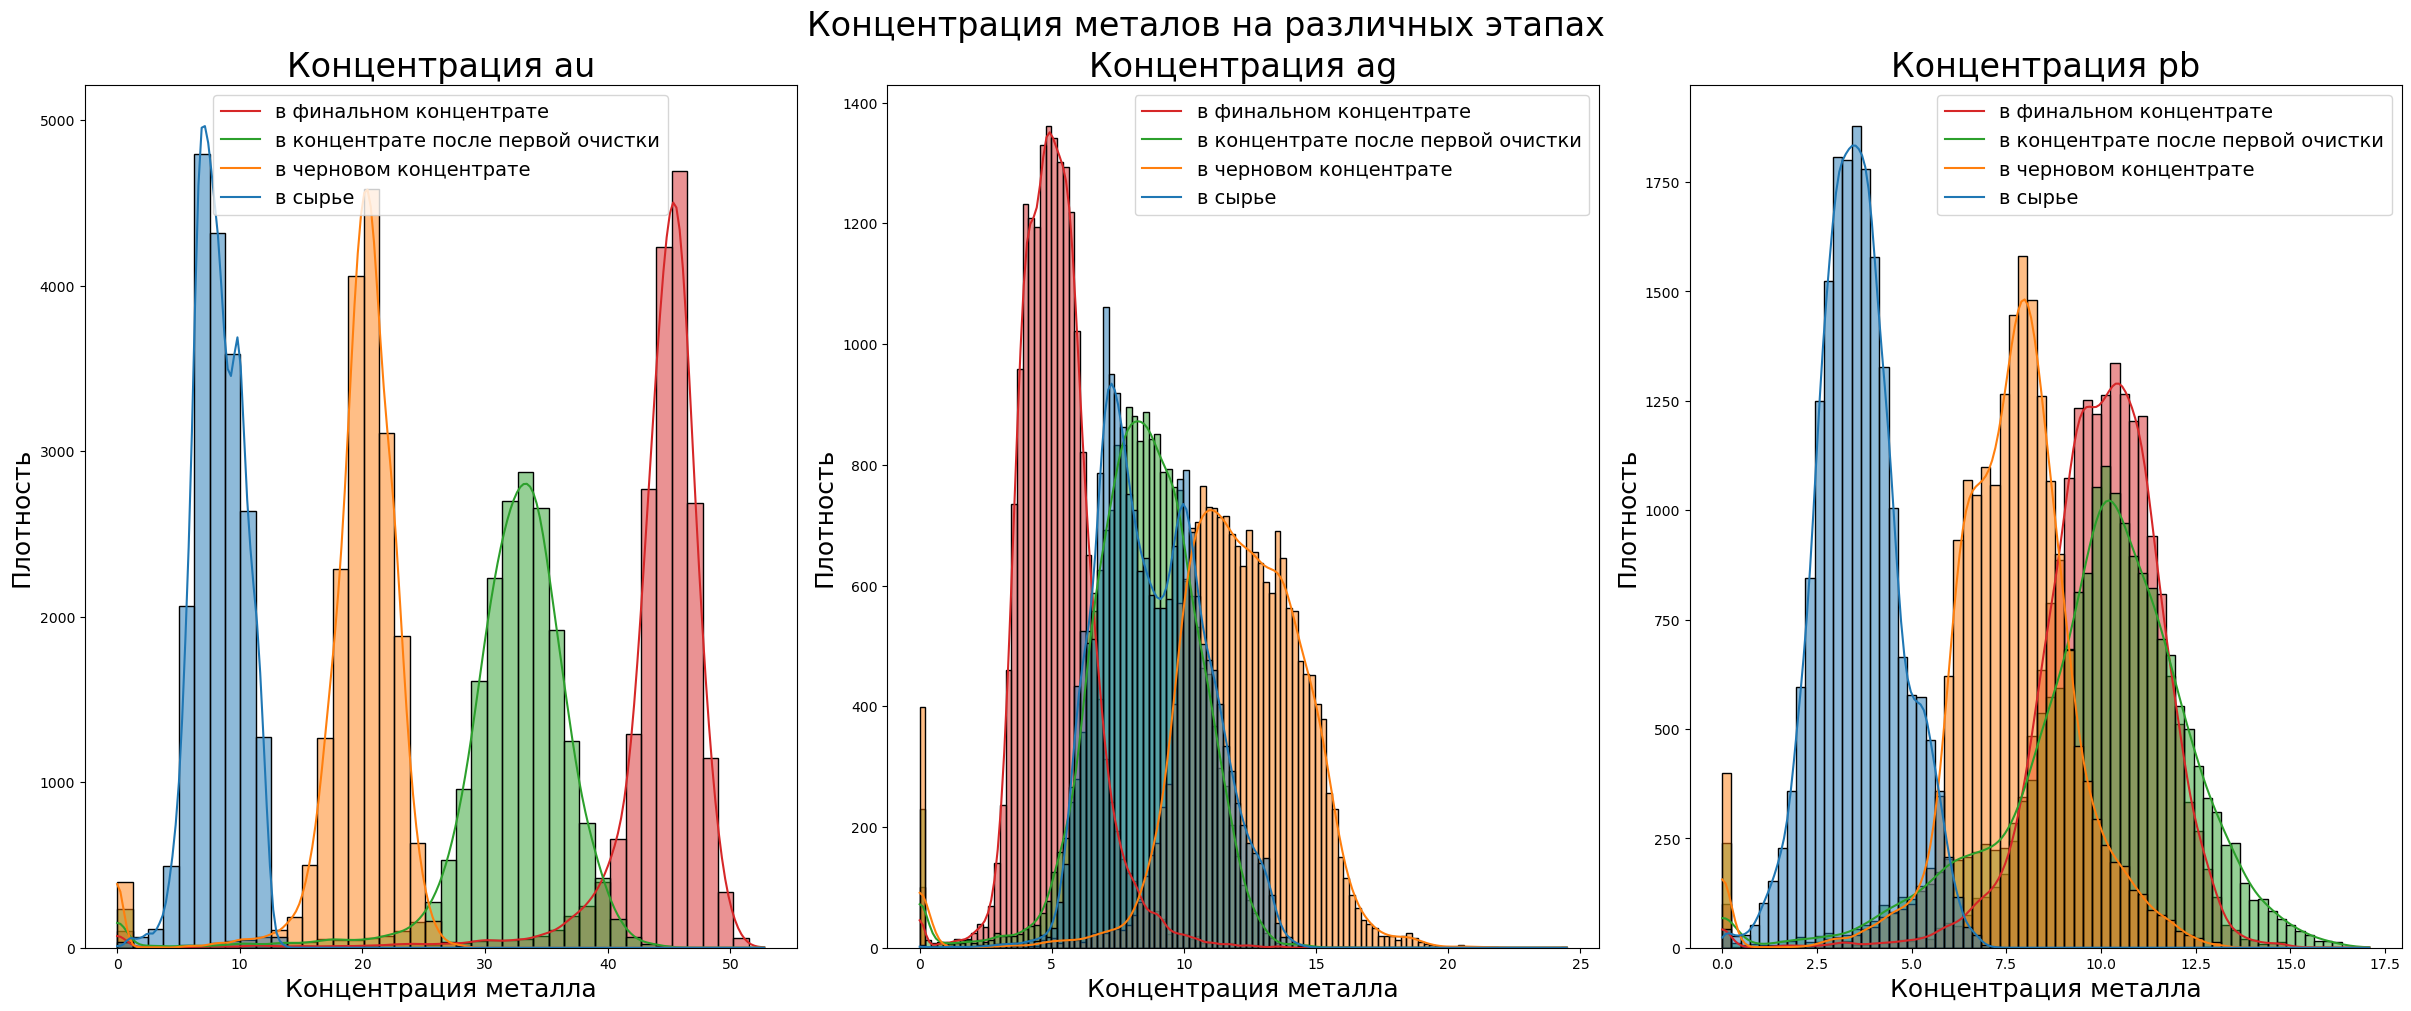

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(24, 10), constrained_layout=True)
fig.suptitle('Концентрация металов на различных этапах', fontsize=24)

for metal, ax in zip(metals, axs): 
    current_stage_name = [stage+metal for stage in stages]
    sns.histplot(df_full[current_stage_name], 
                 label=current_stage_name, ax=ax, 
                 kde=True, linewidth=1) 
    ax.set_title('Концентрация ' + metal, fontsize=24)
    ax.legend(['в финальном концентрате', 'в концентрате после первой очистки', 
               'в черновом концентрате', 'в сырье'], fontsize=14)
    ax.set_xlabel('Концентрация металла', fontsize=18)
    ax.set_ylabel('Плотность', fontsize=18)
    
plt.show()

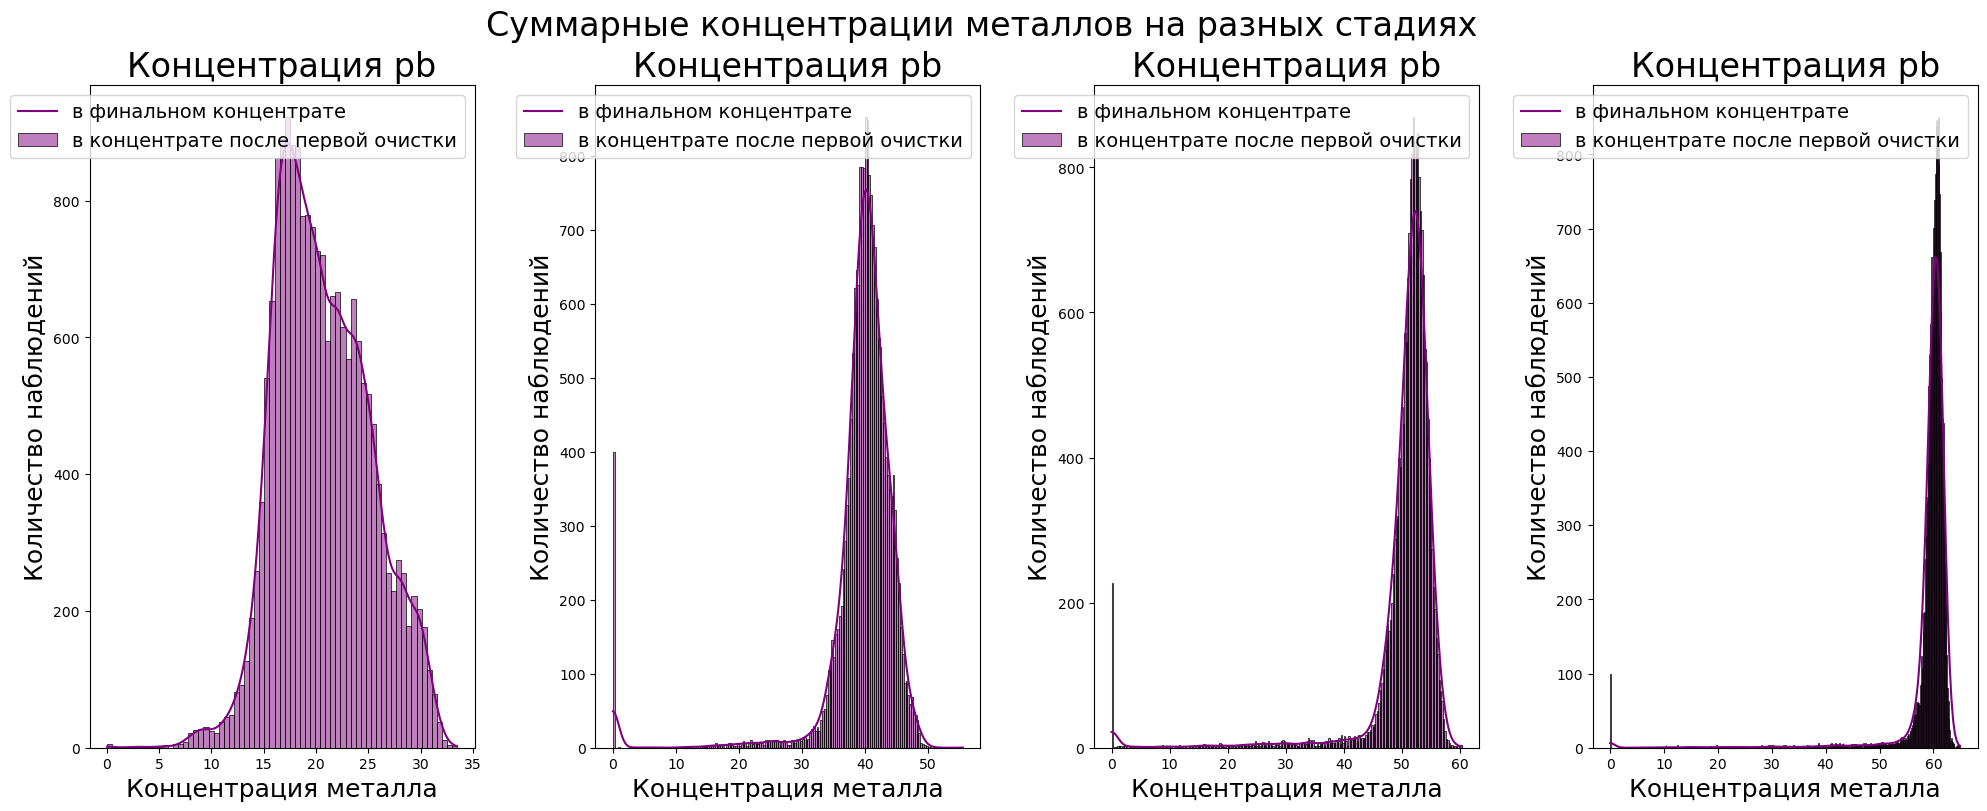

In [20]:
names = ['В сырье', 'В черновом концентрате', 'В концентрате после первой очистки', 'В финальном концентрате']
# Отрисуем графики:
fig, axs = plt.subplots(1, 4, figsize=(20, 8), constrained_layout=True)
fig.suptitle('Cуммарные концентрации металлов на разных стадиях', fontsize=24)

for stage, ax, name in zip(stages, axs, names):
    ax.set_title(stage)
    sum_full = df_full[stage + 'ag'] + df_full[stage + 'au'] + df_full[stage + 'pb']

    sns.histplot(sum_full, label='full', ax=ax, kde=True, linewidth=0.5, color='purple') 
    ax.set_title('Концентрация ' + metal, fontsize=24)
    ax.legend(['в финальном концентрате', 'в концентрате после первой очистки', 
               'в черновом концентрате', 'в сырье'], fontsize=14)
    ax.set_xlabel('Концентрация металла', fontsize=18)
    ax.set_ylabel('Количество наблюдений', fontsize=18)

plt.show()

Концентрация золота закономерно возрастает от начального к конечному этапу - средние значения на финальном этапе находятся в районе 45%.   
Концентрация серебра планомерно снижается в процессе обогащения. На финальном этапе среднее значение концентрации данного материала составляет около 5 %.  
Концентрация свинца меняется незначительно в процессе обогащения, средние значения изменяются от 7.5 до 10 %. Возможно, в процессе первичной очистки по технологии добавляется, а не извлекается свинец.  
Содержание прочих примесей особо велико после флотации, но при первичной очистке оно резко падает (средние значения уменьшаются в 3 раза), вторичная очистка не дает такого эффекта и содержание примесей в растворе почти не меняется. Суммарная концентрация веществ увеличивается с течением процесса обогащения (колокол как бы сдвигается вправо по шкале), что закономерно, т.к. при обработке вымываются примеси и реагенты.  

Посмотрим на ящики с усами

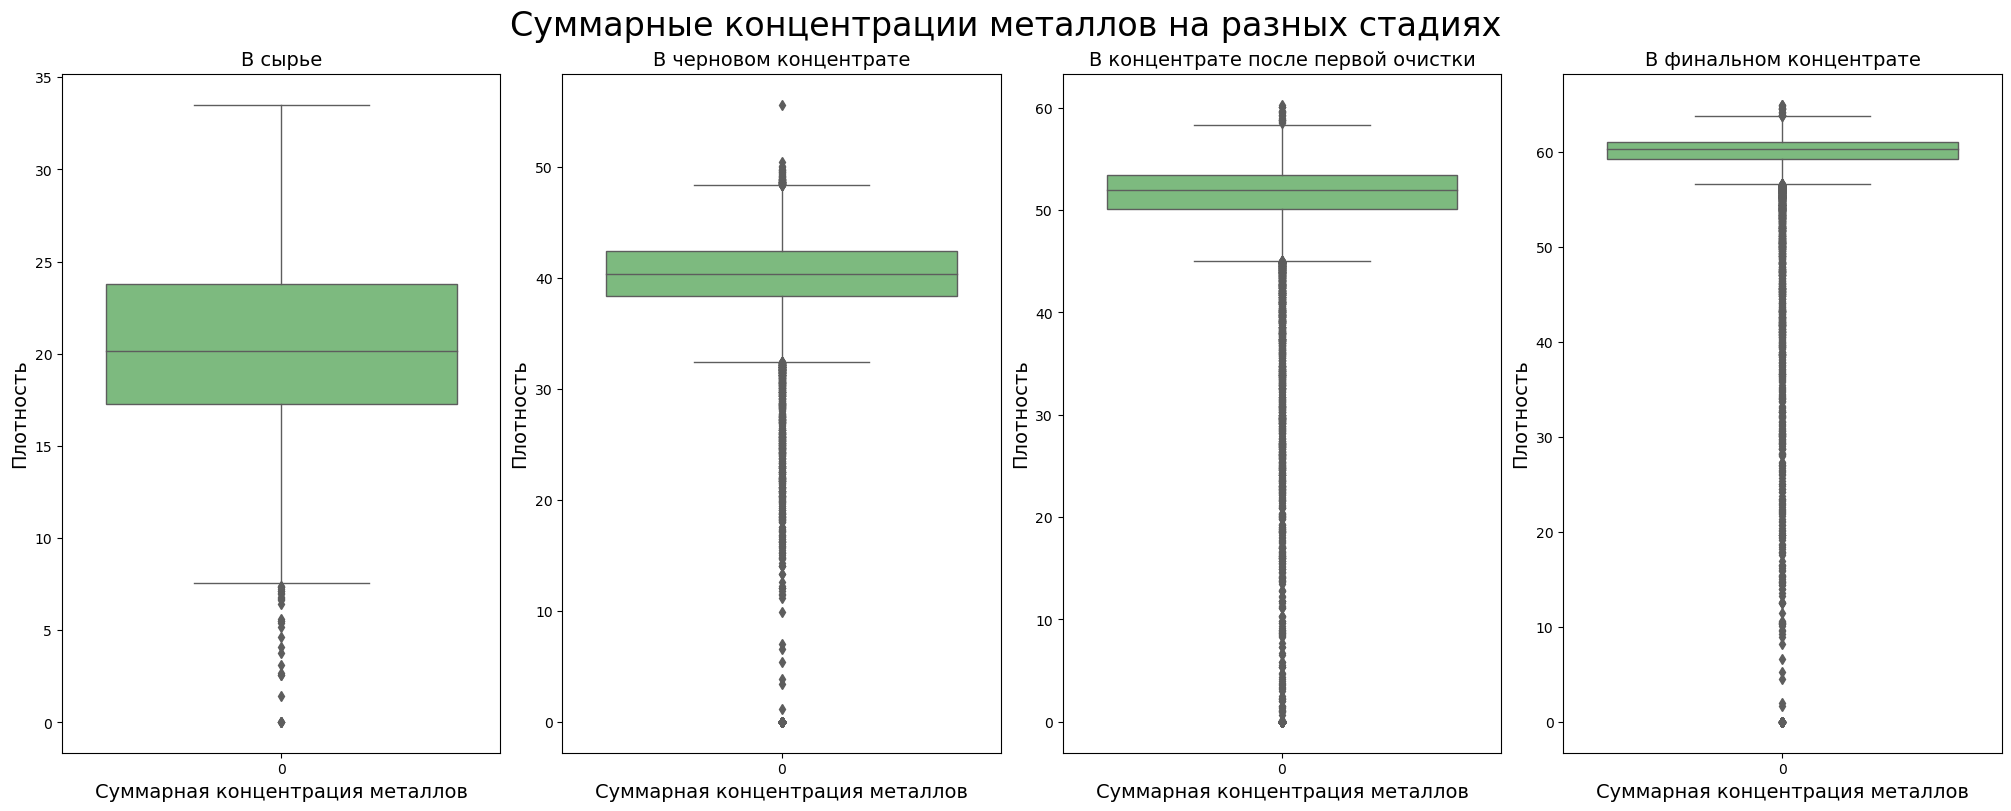

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8), constrained_layout=True)
fig.suptitle('Cуммарные концентрации металлов на разных стадиях', fontsize=24)

for stage, ax, name in zip(stages, axs, names):
    ax.set_title(stage)
    sum_full = df_full[stage + 'ag'] + df_full[stage + 'au'] + df_full[stage + 'pb']
    sns.boxplot(data=sum_full, ax=ax, linewidth=1, palette='Greens') 
    ax.set_xlabel('Суммарная концентрация металлов', fontsize=14)
    ax.set_ylabel('Плотность', fontsize=14)
    ax.set_title(name, fontsize=14)

plt.show()

Длинные хвосты выбросов в распределениях могут указывать на наличие аномалий в данных.   
Нули могут указывать на пустую руду, в которой нет необходимой концентрации металлов.  
На всех графиках наблюдаем аномальные значения около ноля для этапов начиная с флотации. Это может негативно повлиять на качество обучения модели, поэтому удалим их.

In [22]:
# Удалим аномальные значения:
df_train = df_train[(df_train['rougher.output.concentrate_au'] != 0) &
                    (df_train['rougher.output.concentrate_ag'] != 0) &
                    (df_train['rougher.output.concentrate_pb'] != 0)]

df_train = df_train[(df_train['primary_cleaner.output.concentrate_au'] != 0) &
                    (df_train['primary_cleaner.output.concentrate_ag'] != 0) &
                    (df_train['primary_cleaner.output.concentrate_pb'] != 0)]

df_train = df_train[(df_train['final.output.concentrate_au'] != 0) &
                    (df_train['final.output.concentrate_ag'] != 0) &
                    (df_train['final.output.concentrate_pb'] != 0)]

df_full = df_full[(df_full['rougher.output.concentrate_au'] != 0) &
                  (df_full['rougher.output.concentrate_ag'] != 0) &
                  (df_full['rougher.output.concentrate_pb'] != 0)]

df_full = df_full[(df_full['primary_cleaner.output.concentrate_au'] != 0) &
                    (df_full['primary_cleaner.output.concentrate_ag'] != 0) &
                    (df_full['primary_cleaner.output.concentrate_pb'] != 0)]

df_full = df_full[(df_full['final.output.concentrate_au'] != 0) &
                  (df_full['final.output.concentrate_ag'] != 0) &
                  (df_full['final.output.concentrate_pb'] != 0)]

**Сравнение распределения размера гранул сырья на обучающей и тестовых выборках**

p-value (rougher.input.feed_size) = 0.3079341986936012  Распределения статистически не различаются
p-value (primary_cleaner.input.feed_size) = 0.6655608906937527  Распределения статистически не различаются


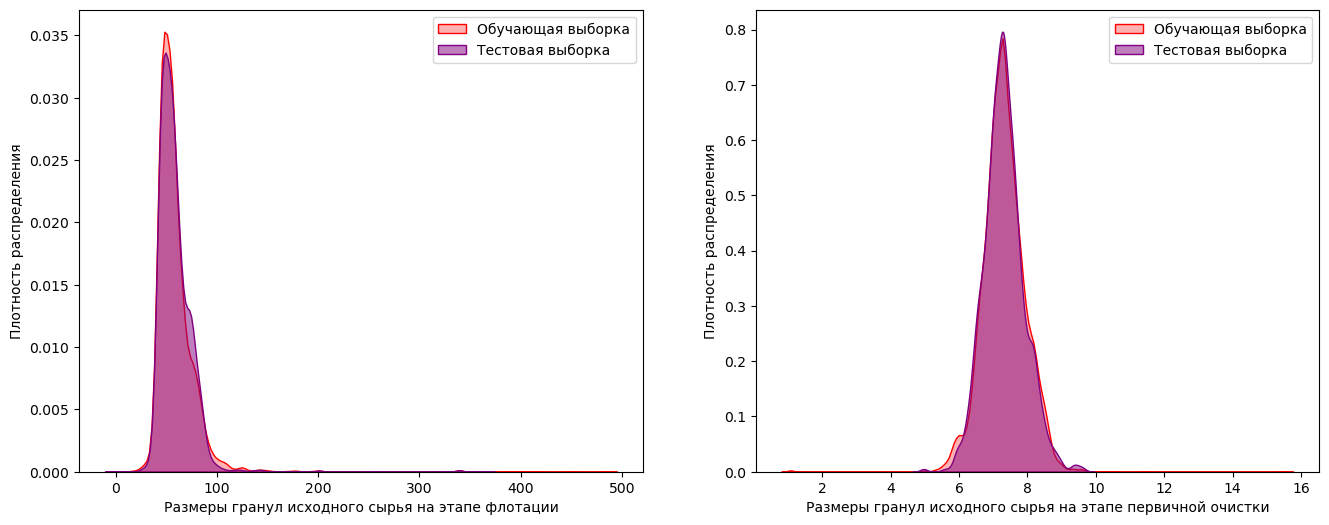

In [23]:
# Для читаемости кода объявим переменные из наших выборок:
train_feature_1 = df_train['rougher.input.feed_size']
train_feature_2 = df_train['primary_cleaner.input.feed_size']
test_feature_1 = df_test['rougher.input.feed_size']
test_feature_2 = df_test['primary_cleaner.input.feed_size']

# Построим гистограммы:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.kdeplot(train_feature_1, alpha=0.3, label='Обучающая выборка', shade=True, ax=axs[0], color='red')
sns.kdeplot(test_feature_1, alpha=0.5, label='Тестовая выборка', shade=True, ax=axs[0], color='purple')
axs[0].set_xlabel('Размеры гранул исходного сырья на этапе флотации')
axs[0].set_ylabel('Плотность распределения')
axs[0].legend()

sns.kdeplot(train_feature_2, alpha=0.3, label='Обучающая выборка', shade=True, ax=axs[1], color='red')
sns.kdeplot(test_feature_2, alpha=0.5, label='Тестовая выборка', shade=True, ax=axs[1], color='purple')
axs[1].set_xlabel('Размеры гранул исходного сырья на этапе первичной очистки')
axs[1].set_ylabel('Плотность распределения')
axs[1].legend()

# Сравним распределение признаков при помощи t-теста:
p_value_1 = ttest_ind(train_feature_1, test_feature_1)[1]
p_value_2 = ttest_ind(train_feature_2, test_feature_2)[1]                                   

# Сравним распределение признаков при помощи теста Колмогорова-Смирнова:
# p_value_1 = stats.ks_2samp(train_feature_1, test_feature_1)[1]
# p_value_2 = stats.ks_2samp(train_feature_2, test_feature_2)[1]

if p_value_1 < 0.05:
    print('p-value (rougher.input.feed_size) =', p_value_1, ' Распределения статистически различаются')
else:
    print('p-value (rougher.input.feed_size) =', p_value_1, ' Распределения статистически не различаются')
    
if p_value_2 < 0.05:
    print('p-value (primary_cleaner.input.feed_size) =', p_value_2, ' Распределения статистически различаются')
else:
    print('p-value (primary_cleaner.input.feed_size) =', p_value_2, ' Распределения статистически не различаются')

Распределения по размерам гранул на трейне и тесте практически совпадают

## Модель

**Создание функции для вычисления итоговой sMAPE**

In [24]:
# функция для вычисления sMAPE
def smape(target, predictions):
    numerator = np.abs(target-predictions)
    denominator =(np.abs(target)+np.abs(predictions))/2
    div_output = np.divide(numerator, denominator)
    output_scores = np.average(div_output[denominator != 0], axis=0)
    
    return output_scores * 100

# основная метрика sMAPE
smape_score = make_scorer(smape, greater_is_better=False)
# функция для вычисления итоговой sMAPE
def final_smape(rougher_smape, cleaner_smape): 
    return 0.25 * rougher_smape + 0.75 * cleaner_smape

Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверем её на тестовой выборке.  
Таргеты:  
rougher.output.recovery - эффективность обогащения чернового концентрата в результате флотации. Для его предсказания нам требуются данные со значением этапа rougher.  
final.output.recovery - эффективность обогащения финального концентрата в результате двух этапов очистки. Для его предсказания нам требуются данные со значением этапов primary_cleaner (первичная очистка) и secondary_cleaner (вторичная очистка).  
Лучшую модель будем выбирать из:  
LinearRegression  
RandomForestRegressor  
GradientBoostingRegressor 
DecisionTreeRegressor  

**Разделение данных на фичи и таргеты**

In [25]:
features_train = df_train.drop(missing_features, axis=1)
target_train = df_train[['rougher.output.recovery', 'final.output.recovery']]

features_test = df_test
target_test = df_full[df_full.index.isin(df_test.index)][['rougher.output.recovery', 'final.output.recovery']]

Соберем признаки для разделения данных по этапам

In [26]:
rougher_column = [name for name in features_train.columns if name.startswith("rougher")]

cleaner_column = [name for name in features_train.columns if (name.startswith('primary_cleaner') or name.startswith('secondary_cleaner'))]

print(
    f'Всего признаков в тесте: {features_train.columns.size}' 
      f'\nКоличество признаков для этапа флотации: {len(rougher_column)}'
      f'\nКоличество признаков для этапа очистки: {len(cleaner_column)}'
)

Всего признаков в тесте: 52
Количество признаков для этапа флотации: 22
Количество признаков для этапа очистки: 30


Разделим фичи и таргеты по этапам

In [27]:
features_train_rougher = features_train[rougher_column]
target_train_rougher = target_train['rougher.output.recovery']

features_train_cleaner = features_train[cleaner_column]
target_train_cleaner = target_train['final.output.recovery']

features_test_rougher = features_test[rougher_column]
target_test_rougher = target_test['rougher.output.recovery']

features_test_cleaner = features_test[cleaner_column]
target_test_cleaner = target_test['final.output.recovery']

Построим константное предсказание для сравнения с ним результатов обучения моделей:

In [28]:
dummy_model = DummyRegressor(strategy='mean') 
dummy_model.fit(features_train, target_train)
dummy_smape = smape(target_test, dummy_model.predict(features_test))
final_dummy_smape = final_smape(dummy_smape[0], dummy_smape[1])
print('Итоговый sMAPE для константного предсказания:', final_dummy_smape)

Итоговый sMAPE для константного предсказания: 8.378333674542972


Настроим pipeline:

In [29]:
# pipeline
pipeline = Pipeline([('scaler', RobustScaler()), ('model', LinearRegression())])

In [30]:
# параметры для моделей
params = [
    {
    },
    {
        'model': [RandomForestRegressor(random_state=42)],
        'model__n_estimators': [int(x) for x in np.linspace(start = 50, stop = 150, num = 20)],
        'model__max_depth': [None] + [int(x) for x in np.linspace(start = 2, stop = 11, num = 9)],
        'model__min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 500, num = 50)],
        'model__max_features':  ['auto', 'sqrt', 'log2']   
    },
    {
        'model': [GradientBoostingRegressor(random_state=42)],
        'model__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'model__n_estimators': [int(x) for x in np.linspace(start = 50, stop = 150, num = 20)]
    },
    {
        'model': [DecisionTreeRegressor(random_state=42)],
        'model__splitter': ['best', 'random'],
        'model__max_depth': [int(x) for x in np.linspace(start = 1, stop = 100, num = 25)],
        'model__max_features': ['auto', 'sqrt', 'log2']
    }
]

In [31]:
# Создадим объект KFold
kf = KFold(n_splits=3, shuffle=True, random_state=50)

In [32]:
# Создадим объект RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline, params, scoring=smape_score, 
    cv=kf, n_jobs=-1, verbose=10, 
    n_iter=50, random_state=50
)

**Подбор модели**

Этап флотации

In [33]:
%%time
# поиск лучшей модели
random_search.fit(features_train_rougher, target_train_rougher)

# лучшая модель, гиперпараметры и sMAPE
rougher_best_estimator = random_search.best_estimator_
rougher_best_params = random_search.best_params_
rougher_best_score = -random_search.best_score_

print('Лучшая модель и ее гиперпараметры:', rougher_best_params)
print('sMAPE:', rougher_best_score)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшая модель и ее гиперпараметры: {'model__n_estimators': 144, 'model__min_samples_leaf': 52, 'model__max_features': 'log2', 'model__max_depth': None, 'model': RandomForestRegressor(max_features='log2', min_samples_leaf=52,
                      n_estimators=144, random_state=42)}
sMAPE: 3.869810107897939
Wall time: 40.1 s


Этап очистки

In [34]:
%%time
# поиск лучшей модели
random_search.fit(features_train_cleaner, target_train_cleaner)

# лучшая модель, гиперпараметры и sMAPE
cleaner_best_estimator = random_search.best_estimator_
cleaner_best_params = random_search.best_params_
cleaner_best_score = -random_search.best_score_

print('Лучшая модель и ее гиперпараметры:', cleaner_best_params)
print('sMAPE:', cleaner_best_score)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшая модель и ее гиперпараметры: {'model__n_estimators': 144, 'model__min_samples_leaf': 52, 'model__max_features': 'log2', 'model__max_depth': None, 'model': RandomForestRegressor(max_features='log2', min_samples_leaf=52,
                      n_estimators=144, random_state=42)}
sMAPE: 7.334716759581876
Wall time: 41.1 s


In [35]:
final_train_smape = final_smape(rougher_best_score, cleaner_best_score)
print('Итоговый sMAPE:', final_train_smape)

Итоговый sMAPE: 6.468490096660892


Наилучшей себя показала модель случайного леса RandomForestRegressor max_features='log2', min_samples_leaf=52, n_estimators=144, random_state=42

Проверим модель на тестовой выборке

In [36]:
%%time
# pipeline
rfr_pipeline = Pipeline([('scaler', RobustScaler()), ('model', RandomForestRegressor())])
rfr_pipeline.set_params(**cleaner_best_params)
rfr_pipeline.fit(features_train, target_train)
smape = smape(target_test, rfr_pipeline.predict(features_test))
final_test_smape = final_smape(smape[0], smape[1])
print('Итоговый sMAPE на тестовой выборке:', final_test_smape)

Итоговый sMAPE на тестовой выборке: 5.925301471677728
Wall time: 4.31 s


Итоговый sMAPE на тестовой выборке получился еще меньше, чем итоговый sMAPE на тренировочной выборке.

In [37]:
pd.Series({
    'Итоговый sMAPE для константного предсказания': final_dummy_smape, 
    'Итоговый sMAPE на тренировочной выборке': final_train_smape, 
    'Итоговый sMAPE на тестовой выборке': final_test_smape,    
})


Итоговый sMAPE для константного предсказания   8.378
Итоговый sMAPE на тренировочной выборке        6.468
Итоговый sMAPE на тестовой выборке             5.925
dtype: float64

**Общий вывод**

Для достижения поставленной задачи проделаны следующие шаги:  

- изучены и подготовлены данные для машинного обучения
- проверен расчёт эффективности обогащения
- проведён исследовательский анализ данных:
  - изучено то, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки
  - при помощи статистического t-теста и графической визуализации исследовано распределение размеров гранул сырья на обучающей и     тестовой выборках
  - исследована суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
- рассмотрено несколько алгоритмов машинного обучения и для итогового предсказания выбран тот алгоритм, который показал наилучший результат по метрике sMAPE.

Выбран алгоритм RandomForestRegressor, выбранная лучшая модель проверена на тестовой выборке, а так же она проверена на адекватность и способность предсказывать при помощи константной модели-заглушки DummyRegressor.

В результате получена модель, которая показала хорошие результаты на тестовой выборке с sMAPE = 5.925. 